### 전처리

> Data
- Input: FMguide에서 다운받은 excel 파일
- Output: csv file (아웃라이어 찾기, Stationary 적용 전 파일)

> Process
1. Excel 데이터 불러오고 기본 데이터프레임 형식으로 전처리
2. rf(risk free rate) 데이터(yfinance) 불러오기 및 데이터 병합
3. ROE 계산
4. COE 계산
5. GM 계산
6. 일반수익률 계산(n일 후 종목 종가 - 종목 종가 / 종목 종가)
7. 상대수익률 계산(종목 수익률 - 시장 수익률)
8. 데이터 내보내기

> 코드 구현 날짜
- 2023-11-01

> 개발환경
- Python version: 3.9.7

> 수정내용
- 수정날짜: 2023-11-08  
- 수정내용:
1. 전처리 코드 함수화
2. 새로 다운받은 20년치 데이터 중 최근 10년 데이터 전처리 및 각종 지표 계산


In [25]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf
import os

In [55]:
# 변수 정의

# 회사 리스트
company_list = ['SK텔레콤', 'KT', 'LG유플러스', '농심', 'CJ제일제당', '오뚜기', '현대차', '한국타이어', 'KB금융', '신한지주']
company = company_list[2] # 회사 선택

# 기간 설정 -> 10년치 데이터만 가져옴
start_dt = '2013-07-01'
end_dt = '2023-06-30'

# 엑셀 파일 경로
filename = '../FMguide_data/gm_model_20years.xlsx'  

### FMguide 데이터 가져오기

In [56]:
# 전처리 함수
def load_data_guide(filename, sheet_name):
    raw_df = pd.read_excel(filename, sheet_name=sheet_name)
    col = raw_df[11:12] # 컬럼명 가져오기
    data = raw_df[13:] # 데이터 가져오기
    df = pd.concat([col, data]) # 컬럼명, 데이터 병합
    df.columns = df.iloc[0] # 컬럼 지정
    df.drop(df.index[0], inplace=True) # 필요없는 첫 행 삭제
    df.rename(columns={df.columns[0]:'Date'}, inplace=True) # 첫번째 컬럼의 컬럼명 변경
    df['Date'] = pd.to_datetime(df['Date']) # 시간형태로 변환
    df = df[(df['Date'] >= start_dt) & (df['Date'] <= end_dt)] # 원하는 기간 설정
    return df

In [57]:
# 함수를 사용해서 파일 읽기
df = load_data_guide(filename, company)
print("회사명: ", company)
df.head()

회사명:  LG유플러스


11,Date,영업이익(천원),금융손익(비영업)(천원),관계기업투자등관련손익(비영업)(천원),종가(원),총자본(천원),PBR(배)
2751,2013-07-01,149210000,-48767000,216000,11800,3981683000,1.29443
2752,2013-07-02,149210000,-48767000,216000,11950,3981683000,1.31089
2753,2013-07-03,149210000,-48767000,216000,12250,3981683000,1.3438
2754,2013-07-04,149210000,-48767000,216000,12650,3981683000,1.38768
2755,2013-07-05,149210000,-48767000,216000,13250,3981683000,1.45349


### COE 계산을 위한 rf 데이터 불러오기

- rf: risk free(미국채 10년물)

In [5]:
# 미국 국채 10년물 불러오는 함수
def load_us_10_year_data(start_date, end_date):
    us_10_year = yf.download("^TNX", start=start_date, end=end_date)
    us_10_year.rename(columns={'Close': 'us_10_treasury'}, inplace=True) # 컬럼명 변경
    us_10_year = us_10_year.reset_index() # Date(인덱스) -> 컬럼으로
    us_10_year = us_10_year[['Date', 'us_10_treasury']] # Date와 미국채 10년물만 가져오기
    return us_10_year

In [6]:
# 데이터 병합
us_10_year = load_us_10_year_data(start_dt, end_dt)
df = pd.merge(df, us_10_year, on='Date', how='outer') # 기존 df와 us_10_year데이터를 Date컬럼 기준으로 merge
df['us_10_treasury'] = df['us_10_treasury'].fillna(method='ffill') # us_10_treasury의 na 값을 ffill로(전날)데이터로 채워줌
#df = df.dropna() # NA인 행 삭제. NA라는 것은 영업일이 아니라는 의미이기 때문(공휴일인듯?)

[*********************100%%**********************]  1 of 1 completed


### Equity(총자본(천원)) 계산

In [7]:
# 분기 나누는 함수
def get_quarter(date):
    year = date.year
    month = date.month

    if 2003 <= year <= 2023:
        if 1 <= month <= 3:
            return f'{year}Q1'
        elif 4 <= month <= 6:
            return f'{year}Q2'
        elif 7 <= month <= 9:
            return f'{year}Q3'
        elif 10 <= month <= 12:
            return f'{year}Q4'
    else:
        return None

In [8]:
df['Quarter'] = df['Date'].apply(get_quarter)

### COE 계산

COE = rf + Beta(MRP)

- Beta: 1
- MRP: 4%
- rf: 미국 국채 10년물

In [9]:
# beta랑 MRP 값
beta = 1
MRP = 4

In [10]:
df['COE'] = df['us_10_treasury'] + beta*MRP

Text(0.5, 1.0, 'COE')

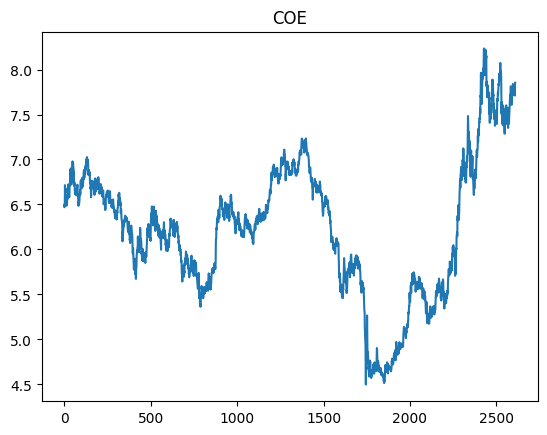

In [12]:
plt.plot(df['COE'])
plt.title("COE")

### ROE, Growth Multiplier 계산

- 순이익 = 영업이익 + 금융손익 + EMS *(1-20%)
- ROE = 순이익 / 총자본
- gm = PBR * COE / ROE

(1-20%): 법인세

In [44]:
# 천원 단위 -> 원 단위
df['영업이익(원)'] = df['영업이익(천원)'] * 1000
df['금융손익(비영업)(원)'] = df['금융손익(비영업)(천원)'] * 1000
df['관계기업투자등관련손익(비영업)(원)'] = df['관계기업투자등관련손익(비영업)(천원)'] * 1000
df['총자본(원)'] = df['총자본(천원)'] * 1000

# 천원 단위 컬럼 삭제
df.drop(columns=['영업이익(천원)', '금융손익(비영업)(천원)', '관계기업투자등관련손익(비영업)(천원)', '총자본(천원)'], inplace=True)

In [45]:
# # ROE, gm 계산 함수
# def calculate_roe(df):
#     df['세전이익'] = df['영업이익(원)'] + df['금융손익(비영업)(원)'] + df['관계기업투자등관련손익(비영업)(원)']
#     df['순이익'] = df['세전이익'] * (1 - 0.2) # 0.2 = 20% 세율 가정
#     df['ROE_tmp'] = df['순이익'] / df['총자본(원)']

#     # 'Year'열을 생성하여 각 날짜의 연도를 추출
#     df['Year'] = df['Date'].dt.year

#     # 연도별로 ROE 값을 더하고, 해당 연도의 분기 수로 나누기
#     # 연도와 분기별로 그룹화 하고 'ROE'의 합계 및 개수를 계산
#     annual_roe = df.groupby('Year')['ROE_tmp'].agg(['sum', 'count']).reset_index()
    
#     # 개수로 합계를 나눠 연도별 평균 ROE 계산
#     annual_roe['Average_ROE'] = annual_roe['sum']/annual_roe['count']
    
#     # 계산된 연도별 평균 ROE를 원래의 데이터프레임에 매핑하기 위한 딕셔너리 생성
#     annual_roe_dict = annual_roe.set_index('Year')['Average_ROE'].to_dict()
    
#     # 원래 데이터프레임에 계산된 연도별 평균 ROE 적용
#     df['ROE'] = (df['Year'].map(annual_roe_dict)) * 100 # %화

#     # gm 계산
#     df['gm'] = (df['PBR(배)'] * df['COE']) / df['ROE']

#     # 필요없는 'Year', ROE_tmp 컬럼 삭제
#     #df.drop(columns=['Year'], inplace=True)
#     df.drop(columns=['ROE_tmp'], inplace=True)

#     return df, annual_roe, annual_roe_dict

In [46]:
# ROE, gm 계산 함수 version.2
def calculate_roe(df):
    df['세전이익'] = df['영업이익(원)'] + df['금융손익(비영업)(원)'] + df['관계기업투자등관련손익(비영업)(원)']
    df['순이익'] = df['세전이익'] * (1 - 0.2) # 0.2 = 20% 세율 가정
    df['ROE_tmp'] = df['순이익'] / df['총자본(원)']

    # 'Year'와 'Quarter' 열 추가
    df['Year'] = df['Quarter'].str[:4]
    df['Year'] = df['Year'].astype(int) # 연도를 정수형으로 변환

    # 연도별 평균 ROE 계산
    annual_roe = df.groupby('Year')['ROE_tmp'].agg(lambda x: x.unique().sum() / x.nunique()).reset_index().rename(columns={'ROE_tmp':'Average_ROE'})
    
    
    # 연도별 평균 ROE를 원본 데이터프레임에 매핑
    annual_roe_dict = annual_roe.set_index('Year')['Average_ROE'].to_dict()
    df['ROE'] = df['Year'].map(annual_roe_dict) * 100 # %로 변환

    # gm 계산
    df['gm'] = (df['PBR(배)'] * df['COE']) / df['ROE']

    # 불필요한 'Year', 'ROE_tmp' 컬럼 삭제
    #df.drop(columns=['Year'], inplace=True)
    df.drop(columns=['ROE_tmp'], inplace=True)

    return df

In [47]:
# ROE 계산
df = calculate_roe(df)

In [49]:
# 모든 행 출력되도록
#pd.set_option('display.max_rows', None)

### 시점&수익률 생성 

In [50]:
# 각 시점의 일주일, 이주일, 한달뒤 종가 값을 가진 컬럼 생성
df['종가_1주후'] = df['종가(원)'].shift(-5) # 1주
df['종가_2주후'] = df['종가(원)'].shift(-10) # 2주
df['종가_1달후'] = df['종가(원)'].shift(-20) # 1달
df['종가_3달후'] = df['종가(원)'].shift(-60) # 3달
df['종가_6달후'] = df['종가(원)'].shift(-120) # 6달

### 일반 수익률

In [51]:
# 각 시점의 1주후, 2주후, 한달후 수익률 구하기 + 수익률 -> %로
df['수익률_1주후'] = (df['종가_1주후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_2주후'] = (df['종가_2주후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_1달후'] = (df['종가_1달후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_3달후'] = (df['종가_3달후'] - df['종가(원)']) / df['종가(원)'] * 100
df['수익률_6달후'] = (df['종가_6달후'] - df['종가(원)']) / df['종가(원)'] * 100

### 코스피(시장) 수익률 계산

In [52]:
# 코스피 지수 데이터 가져오기
df_kospi = yf.download('^KS11', start_dt, end_dt)
df_kospi = df_kospi.reset_index() # index -> column
df = df.merge(df_kospi[['Date', 'Adj Close']]) # df에 df_kospi "Adj Close" 값 병합
df.rename(columns={'Adj Close': 'kospi'}, inplace=True) # 컬럼명 변경

[*********************100%%**********************]  1 of 1 completed


In [53]:
# 각 시점의 일주일, 이주일, 한달뒤 종가 값을 가진 컬럼 생성
df['kospi_1주후'] = df['kospi'].shift(-5) # 1주
df['kospi_2주후'] = df['kospi'].shift(-10) # 2주
df['kospi_1달후'] = df['kospi'].shift(-20) # 1달
df['kospi_3달후'] = df['kospi'].shift(-60) # 3달
df['kospi_6달후'] = df['kospi'].shift(-120) # 6달

In [54]:
# 각 시점의 1주후, 2주후, 한달후 수익률 구하기 + 수익률 -> %로
df['kospi_수익률_1주후'] = (df['kospi_1주후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_2주후'] = (df['kospi_2주후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_1달후'] = (df['kospi_1달후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_3달후'] = (df['kospi_3달후'] - df['kospi']) / df['kospi'] * 100
df['kospi_수익률_6달후'] = (df['kospi_6달후'] - df['kospi']) / df['kospi'] * 100

In [55]:
# 지수를 얼마나 이겼는지 (상대)수익률
df['상대수익률_1주후'] = df['수익률_1주후'] - df['kospi_수익률_1주후']
df['상대수익률_2주후'] = df['수익률_2주후'] - df['kospi_수익률_2주후']
df['상대수익률_1달후'] = df['수익률_1달후'] - df['kospi_수익률_1달후']
df['상대수익률_3달후'] = df['수익률_3달후'] - df['kospi_수익률_3달후']
df['상대수익률_6달후'] = df['수익률_6달후'] - df['kospi_수익률_6달후']

### 데이터 내보내기

In [56]:
# 저장할 폴더 경로 지정
folder_path = '../gm_data'

# 폴더가 없으면 생성
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# CSV 파일 저장
df.to_csv(f'{folder_path}/{company}_df.csv', index=False)
